<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Pointnet" data-toc-modified-id="Pointnet-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Pointnet</a></span></li><li><span><a href="#Import-necessary-libraries" data-toc-modified-id="Import-necessary-libraries-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Import necessary libraries</a></span><ul class="toc-item"><li><span><a href="#Trimesh" data-toc-modified-id="Trimesh-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Trimesh</a></span></li></ul></li><li><span><a href="#Dataset" data-toc-modified-id="Dataset-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Dataset</a></span><ul class="toc-item"><li><span><a href="#Loading-the-dataset" data-toc-modified-id="Loading-the-dataset-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Loading the dataset</a></span></li><li><span><a href="#Function-to-parse-data" data-toc-modified-id="Function-to-parse-data-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Function to parse data</a></span></li><li><span><a href="#Data-augmentation" data-toc-modified-id="Data-augmentation-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Data augmentation</a></span></li></ul></li><li><span><a href="#Building-the-Pointnet-model" data-toc-modified-id="Building-the-Pointnet-model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Building the Pointnet model</a></span><ul class="toc-item"><li><span><a href="#Functions-to-build-model" data-toc-modified-id="Functions-to-build-model-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Functions to build model</a></span></li><li><span><a href="#Function-to-create-tnet-layers" data-toc-modified-id="Function-to-create-tnet-layers-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Function to create tnet layers</a></span></li><li><span><a href="#Create-the-Convolutional-Neural-Network" data-toc-modified-id="Create-the-Convolutional-Neural-Network-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Create the Convolutional Neural Network</a></span></li></ul></li><li><span><a href="#Compile-and-train-the-model" data-toc-modified-id="Compile-and-train-the-model-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Compile and train the model</a></span></li><li><span><a href="#Visualize-the-predictions" data-toc-modified-id="Visualize-the-predictions-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Visualize the predictions</a></span></li></ul></div>

# Pointnet

PointNet is a deep learning neural network architecture for processing point clouds, which are unordered sets of points in 3D space. It was introduced by Charles R. Qi et al. in a 2017 paper titled "PointNet: Deep Learning on Point Sets for 3D Classification and Segmentation".

The PointNet architecture can take in a point cloud as input and produce a fixed-size feature vector that represents the entire point cloud. This feature vector can then be used for various downstream tasks such as object classification, part segmentation, and scene semantic segmentation.

PointNet uses a combination of multi-layer perceptrons (MLPs) and max-pooling operations to extract features from individual points, and a symmetric function to aggregate these features into a global feature vector that represents the entire point cloud. PointNet has been shown to achieve state-of-the-art performance on several benchmark datasets for point cloud processing tasks.

![pointnet](images/pointnet.png)
![pointnet](images/pointnet2.png)

# Import necessary libraries

In [16]:
# !pip install trimesh
# !pip install tensorflow
import os
import glob
import trimesh
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

tf.random.set_seed(1234)

## Trimesh

Trimesh is a Python library used for **loading, manipulating and exporting 3D mesh models**. It provides functionalities to load and save mesh files in various formats, perform geometric operations on meshes such as transforming, merging, smoothing, simplifying, and many others. It also includes visualization tools to visualize the mesh models and plot the results of the geometric operations. Trimesh can be used in various fields, such as computer graphics, robotics, and scientific simulations.

**Subdivision** is a technique to increase the number of faces in a mesh model by subdividing each face into smaller triangles or quadrilaterals. The process of subdivision can be repeated iteratively to generate a mesh with an arbitrary number of faces. The resulting mesh model is smoother and more detailed than the original one, but it can also increase the complexity and memory usage of the model. 

In [28]:
# create a 3D sphere mesh
sphere = trimesh.creation.icosphere(radius=1.0, subdivisions=3)
# visualize the mesh
sphere.show()

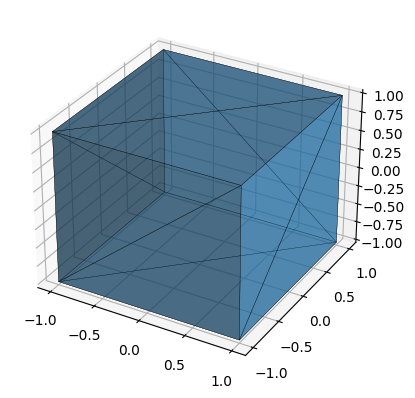

In [15]:
import trimesh
import numpy as np

# Create a cube mesh
vertices = np.array([
    [-1, -1, -1],
    [ 1, -1, -1],
    [ 1,  1, -1],
    [-1,  1, -1],
    [-1, -1,  1],
    [ 1, -1,  1],
    [ 1,  1,  1],
    [-1,  1,  1],
])
faces = np.array([
    [0, 1, 2],
    [0, 2, 3],
    [4, 6, 5],
    [4, 7, 6],
    [0, 4, 5],
    [0, 5, 1],
    [1, 5, 6],
    [1, 6, 2],
    [2, 6, 7],
    [2, 7, 3],
    [4, 0, 3],
    [4, 3, 7],
])
mesh = trimesh.Trimesh(vertices=vertices, faces=faces)

# Plot the vertices and faces
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(mesh.vertices[:, 0], mesh.vertices[:, 1], mesh.vertices[:, 2], triangles=mesh.faces, linewidth=0.2, edgecolor='black', alpha=0.5)
plt.show()

# Dataset

download the dataset at http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip

## Loading the dataset

In [22]:
mesh = trimesh.load("ModelNet10/chair/train/chair_0001.off")
mesh.show()

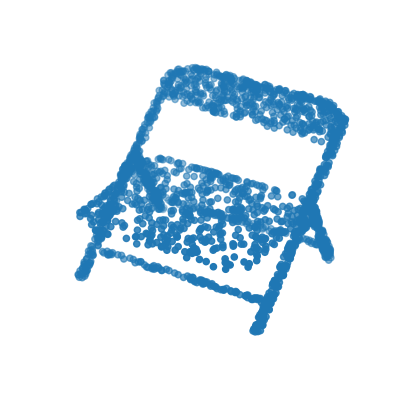

In [27]:
# sample these many point from the mesh and visualize
points = mesh.sample(2048)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.set_axis_off()
plt.show()

## Function to parse data

In [40]:
def parse_dataset(num_points=2048):

    train_points = []
    train_labels = []
    test_points = []
    test_labels = []
    class_map = {}
    folders = glob.glob(os.path.join("ModelNet10", "[!README]*"))
    print(folders)

    for i, folder in enumerate(folders):
        print("processing class: {}".format(os.path.basename(folder)))
        # store folder name with ID so we can retrieve later
        class_map[i] = folder.split("/")[-1]
        # gather all files
        train_files = glob.glob(os.path.join(folder, "train/*"))
        test_files = glob.glob(os.path.join(folder, "test/*"))

        for f in train_files:
            
            train_points.append(trimesh.load(f).sample(num_points))
            train_labels.append(i)

        for f in test_files:
            test_points.append(trimesh.load(f).sample(num_points))
            test_labels.append(i)

    return (
        np.array(train_points),
        np.array(test_points),
        np.array(train_labels),
        np.array(test_labels),
        class_map,
    )

In [41]:
NUM_POINTS = 2048
NUM_CLASSES = 10
BATCH_SIZE = 32

train_points, test_points, train_labels, test_labels, CLASS_MAP = parse_dataset(NUM_POINTS)

['ModelNet10/bed', 'ModelNet10/sofa', 'ModelNet10/dresser', 'ModelNet10/monitor', 'ModelNet10/night_stand', 'ModelNet10/chair', 'ModelNet10/table', 'ModelNet10/toilet', 'ModelNet10/desk', 'ModelNet10/bathtub']
processing class: bed
processing class: sofa
processing class: dresser
processing class: monitor
processing class: night_stand
processing class: chair
processing class: table
processing class: toilet
processing class: desk
processing class: bathtub


In [42]:
print(len(train_points))

3991


## Data augmentation

it performs two types of data augmentation.

Firstly, it adds random noise (jitter) to the points array, by uniformly sampling from a range of -0.005 to 0.005 and adding this value to each element of the array. This helps to make the model more robust to small perturbations in the input data.

Secondly, it shuffles the points array. This helps to avoid any ordering biases that may exist in the data.

In [44]:
def augment(points, label):
    # jitter points
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
    # shuffle points
    points = tf.random.shuffle(points)
    return points, label


train_dataset = tf.data.Dataset.from_tensor_slices((train_points, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_points, test_labels))

train_dataset = train_dataset.shuffle(len(train_points)).map(augment).batch(BATCH_SIZE)
test_dataset = test_dataset.shuffle(len(test_points)).batch(BATCH_SIZE)

2023-04-18 09:04:30.541234: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 196165632 exceeds 10% of free system memory.


# Building the Pointnet model

## Functions to build model

In [45]:
def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)


def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

In [46]:
class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))

## Function to create tnet layers

In [47]:
def tnet(inputs, num_features):

    # Initalise bias as the indentity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)

    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    return layers.Dot(axes=(2, 1))([inputs, feat_T])

## Create the Convolutional Neural Network

In [48]:
inputs = keras.Input(shape=(NUM_POINTS, 3))

x = tnet(inputs, 3)
x = conv_bn(x, 32)
x = conv_bn(x, 32)
x = tnet(x, 32)
x = conv_bn(x, 32)
x = conv_bn(x, 64)
x = conv_bn(x, 512)
x = layers.GlobalMaxPooling1D()(x)
x = dense_bn(x, 256)
x = layers.Dropout(0.3)(x)
x = dense_bn(x, 128)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
model.summary()

Model: "pointnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2048, 3)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 2048, 32)     128         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 2048, 32)    128         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 2048, 32)     0           ['batch_normalization[0][0

 activation_9 (Activation)      (None, 2048, 512)    0           ['batch_normalization_9[0][0]']  
                                                                                                  
 global_max_pooling1d_1 (Global  (None, 512)         0           ['activation_9[0][0]']           
 MaxPooling1D)                                                                                    
                                                                                                  
 dense_3 (Dense)                (None, 256)          131328      ['global_max_pooling1d_1[0][0]'] 
                                                                                                  
 batch_normalization_10 (BatchN  (None, 256)         1024        ['dense_3[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 activatio

# Compile and train the model

In [50]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

model.fit(train_dataset, epochs=2, validation_data=test_dataset)

Epoch 1/2
125/125 [==============================] - 340s 3s/step - loss: 2.9449 - sparse_categorical_accuracy: 0.4202 - val_loss: 47499213537280.0000 - val_sparse_categorical_accuracy: 0.3976
Epoch 2/2
125/125 [==============================] - 318s 3s/step - loss: 2.6428 - sparse_categorical_accuracy: 0.5019 - val_loss: 4.6876 - val_sparse_categorical_accuracy: 0.1630


# Visualize the predictions

1/1 [==============================] - 0s 113ms/step


2023-04-18 09:32:18.200039: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [908]
	 [[{{node Placeholder/_1}}]]


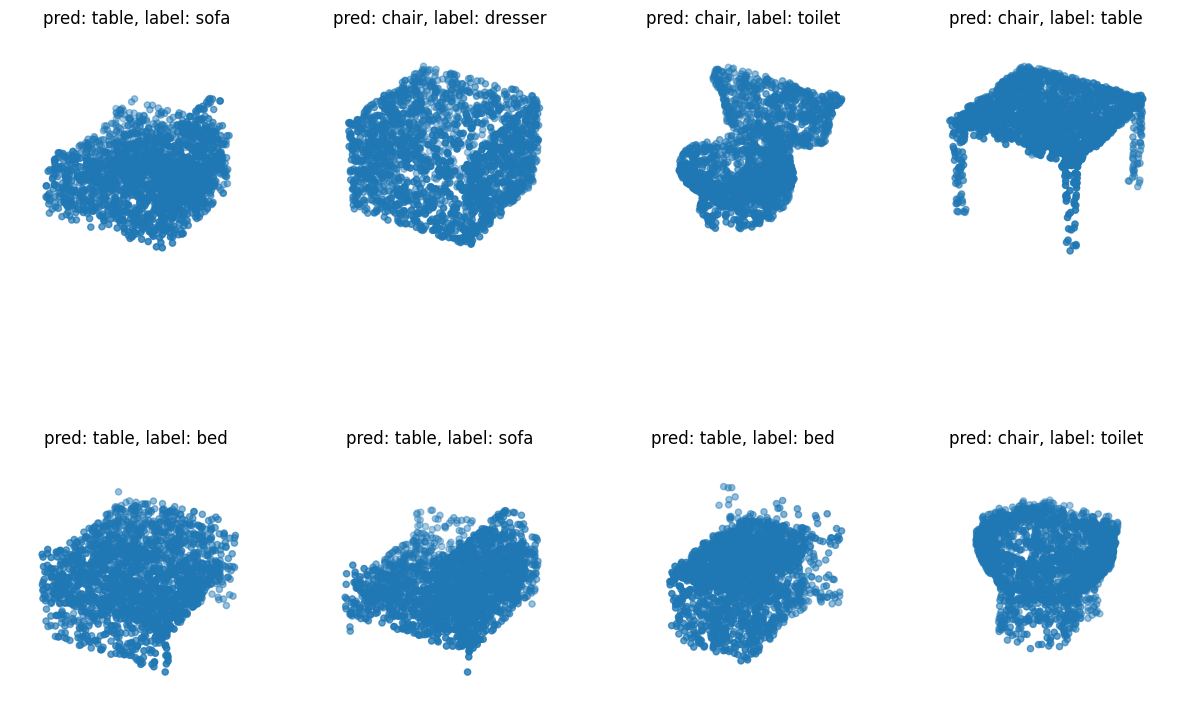

In [54]:
data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]

# run test data through model
preds = model.predict(points)
preds = tf.math.argmax(preds, -1)

points = points.numpy()

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(
            CLASS_MAP[preds[i].numpy()], CLASS_MAP[labels.numpy()[i]]
        )
    )
    ax.set_axis_off()
plt.show()